In [1]:
# pip install -q numpy matplotlib scipy cvxpy osqp


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete
import cvxpy as cp
import os

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["figure.dpi"] = 120


In [3]:
# Physical parameters
g = 9.81
h = 0.8
omega = np.sqrt(g / h)

# Timing
dt = 0.02          # 50 Hz
T_total = 8.0
steps = int(T_total / dt)

# Continuous-time state space:
# x = [c; c_dot], xdot = Ac x + Bc p
Ac = np.array([[0.0, 1.0],
               [omega**2, 0.0]])
Bc = np.array([[0.0],
               [-omega**2]])

Ad, Bd, _, _, _ = cont2discrete((Ac, Bc, np.eye(2), np.zeros((2,1))), dt)
Bd = Bd.reshape(2, 1)

Ad, Bd


(array([[1.0024535 , 0.02001635],
        [0.24545054, 1.0024535 ]]),
 array([[-0.0024535 ],
        [-0.24545054]]))

In [36]:
# --- Reference parameters ---
v_final = 0.25   # target walking speed (m/s)  (smaller is easier)
tau = 1.0        # ramp time constant (s)
c0_ref = 0.0

def v_ref_t(t):
    # smooth ramp from 0 to v_final
    return v_final * (1 - np.exp(-t / tau))

def com_ref(t):
    # integral of v_final*(1-exp(-t/tau)) with com_ref(0)=0
    return c0_ref + v_final * (t - tau * (1 - np.exp(-t / tau)))

# --- Foot/support model ---
step_length = 0.18  # must NOT be larger than how far COM reference moves per step
half_foot = 0.12    # larger support makes it easier/stable

def foot_center_at_time(t):
    # Keep stance foot behind/under the reference COM (prevents "foot jumps ahead")
    cr = com_ref(t)
    k = int(np.floor(cr / step_length))
    return k * step_length

def zmp_bounds_at_time(t):
    fc = foot_center_at_time(t)
    return fc - half_foot, fc + half_foot


In [38]:
# MPC horizon
N = 60  # 1.2s lookahead at dt=0.02

# Weights (more stable set)
w_c  = 200.0   # COM position tracking
w_v  = 20.0    # COM velocity tracking
w_dp = 20.0    # ZMP smoothness
w_p  = 1e-3    # tiny regularization on ZMP magnitude (stabilizes numerics)


In [40]:
# Storage
x = np.zeros((2, steps + 1))        # [c; c_dot]
p_applied = np.zeros(steps)
pmin_hist = np.zeros(steps)
pmax_hist = np.zeros(steps)
c_ref_hist = np.zeros(steps)
v_ref_hist = np.zeros(steps)

# Initial condition
x[:, 0] = np.array([0.0, 0.0])
p_prev = 0.0

for k in range(steps):
    t0 = k * dt

    # Decision variables
    X = cp.Variable((2, N+1))
    P = cp.Variable((N, 1))

    constraints = [X[:, 0] == x[:, k]]
    cost = 0

    for i in range(N):
        ti = t0 + i * dt

        # References
        c_r = com_ref(ti)
        v_r = v_ref_t(ti)

        # ZMP bounds
        pmin, pmax = zmp_bounds_at_time(ti)

        # Dynamics
        constraints += [X[:, i+1] == Ad @ X[:, i] + Bd.flatten() * P[i, 0]]

        # ZMP bounds
        constraints += [P[i, 0] >= pmin, P[i, 0] <= pmax]

        # Tracking cost
        cost += w_c * cp.square(X[0, i] - c_r)
        cost += w_v * cp.square(X[1, i] - v_r)

        # Smoothness cost
        if i == 0:
            cost += w_dp * cp.square(P[i, 0] - p_prev)
        else:
            cost += w_dp * cp.square(P[i, 0] - P[i-1, 0])

        # Small regularization to improve conditioning
        cost += w_p * cp.square(P[i, 0])

    prob = cp.Problem(cp.Minimize(cost), constraints)

    prob.solve(
        solver=cp.OSQP,
        warm_start=True,
        verbose=False,
        eps_abs=1e-6,
        eps_rel=1e-6,
        max_iter=200000,
        polish=True
    )

    if P.value is None:
        raise RuntimeError(f"MPC failed at step {k}, time {t0:.2f}s. Status={prob.status}")

    # Apply first ZMP
    p_k = float(P.value[0, 0])
    p_applied[k] = p_k
    p_prev = p_k

    # Log bounds and refs
    pmin, pmax = zmp_bounds_at_time(t0)
    pmin_hist[k] = pmin
    pmax_hist[k] = pmax
    c_ref_hist[k] = com_ref(t0)
    v_ref_hist[k] = v_ref_t(t0)

    # Step forward
    x[:, k+1] = (Ad @ x[:, k].reshape(2, 1) + Bd * p_k).flatten()

print("Simulation finished. Status:", prob.status)


Simulation finished. Status: optimal


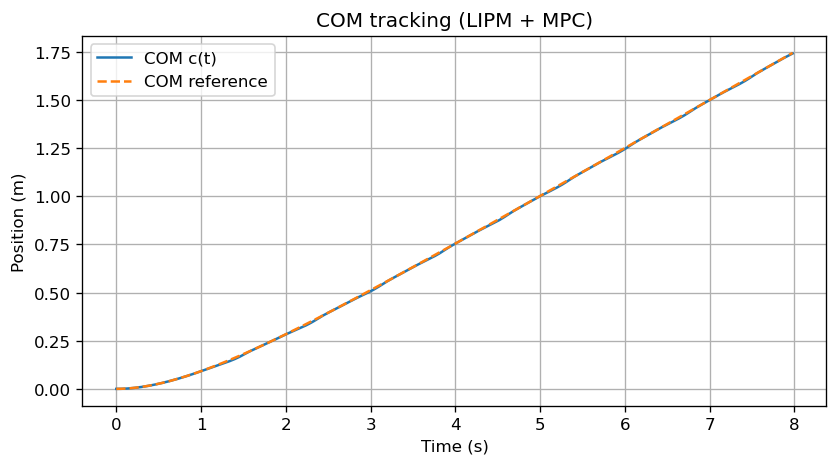

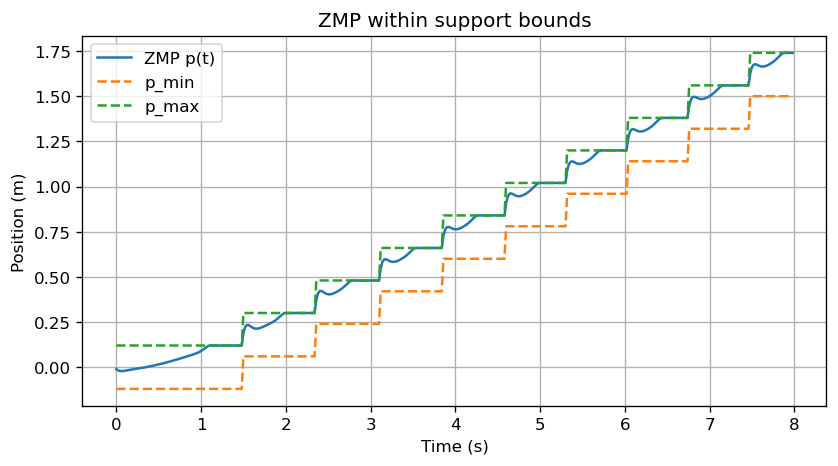

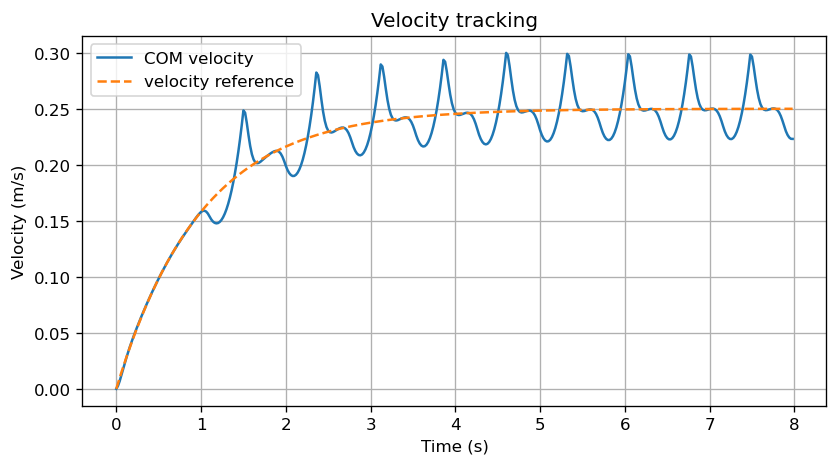

In [42]:
t = np.arange(steps) * dt

plt.figure()
plt.plot(t, x[0, :steps], label="COM c(t)")
plt.plot(t, c_ref_hist, "--", label="COM reference")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("COM tracking (LIPM + MPC)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(t, p_applied, label="ZMP p(t)")
plt.plot(t, pmin_hist, "--", label="p_min")
plt.plot(t, pmax_hist, "--", label="p_max")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("ZMP within support bounds")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(t, x[1, :steps], label="COM velocity")
plt.plot(t, v_ref_hist, "--", label="velocity reference")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity tracking")
plt.grid(True)
plt.legend()
plt.show()


In [44]:
os.makedirs("outputs", exist_ok=True)

# Recreate plots and save
t = np.arange(steps) * dt

plt.figure()
plt.plot(t, x[0, :steps], label="COM c(t)")
plt.plot(t, c_ref_hist, "--", label="COM reference")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("COM tracking (LIPM + MPC)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("outputs/com_tracking.png", dpi=200)
plt.close()

plt.figure()
plt.plot(t, p_applied, label="ZMP p(t)")
plt.plot(t, pmin_hist, "--", label="p_min (foot bound)")
plt.plot(t, pmax_hist, "--", label="p_max (foot bound)")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("ZMP within support bounds")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("outputs/zmp_bounds.png", dpi=200)
plt.close()

print("Saved: outputs/com_tracking.png and outputs/zmp_bounds.png")


Saved: outputs/com_tracking.png and outputs/zmp_bounds.png
